# Meta Analysis
![](./images/Module5/Module5.jpg)

Meta pathway analysis using multiple omics data is a rapidly emerging field in bioinformatics and systems biology that allows for the integration of diverse omics data from genomics, transcriptomics, proteomics, metabolomics, and other molecular biology disciplines. By integrating multiple omics data, meta pathway analysis aims to provide a comprehensive understanding of the cellular functions and molecular mechanisms underlying biological processes in a given organism. This approach offers a powerful means to investigate the complex interplay between genes, proteins, and metabolites in different biological contexts, such as disease states or environmental conditions. Moreover, meta pathway analysis can identify key regulatory pathways and molecular signatures that are critical for the development of targeted therapeutics and precision medicine. Overall, the integration of multiple omics data through meta pathway analysis has the potential to reveal new insights into the underlying biology of complex diseases and to guide the development of personalized treatments. In this submodule, we will demonstrate the power of meta-analysis to find the significant pathways for Alzheimer and Parkinson diseases.

## Learning Objectives:
1. Downloading processed data
2. Performing enrichment analysis using FGSEA and plotting results
3. Performing meta-analysis and plotting results

### Table of Contents

1. [Example Analyses using FGSEA](#EA-main)
2. [Meta-Analysis](#meta-main)

In [1]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5.html" width=100% height=250></iframe>')

### Data loading
In this submodule 5, we will the two datasets (GSE5281 and GSE153873) that we have been using throughout the 4 previous submodules. We will examine the result of the `fgsea` pathway analysis method on each dataset and use a meta-analysis method to combine the results. We will first need to load the differential analysis results of the two dataset to perform pathway analysis using `fgsea`. 

In [2]:
# Download the GSE48350.rds file to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GSE5281.rds ./data/")
system("gsutil cp gs://ccpa_bucket/GSE153873.rds ./data/")


# Download the GO_terms.gmt, KEGG_pathways.gmt, REACTOME_pathways.gmt files to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GO_terms.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/KEGG_pathways.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/REACTOME_pathways.gmt ./data/")

In [3]:
# Load previously saved data
gse5281Data <- readRDS("./data/GSE5281.rds")
gse5281LimmaRes <- gse5281Data$limma_results
gse5281LimmaRes$sampleSize <- ncol(gse5281Data$expression_data)
# Load previously saved data
gse153873Data <- readRDS("./data/GSE153873.rds")
gse153873LimmaRes <- gse153873Data$limma_results
gse153873LimmaRes$sampleSize <- ncol(gse153873Data$expression_data)
head(gse153873LimmaRes)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr,sampleSize
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
LOC101926975,LOC101926975,3.656235e-09,9.921193e-05,-8.344000,-1.8227116,3.023096,30
ZNF596,ZNF596,1.039453e-07,9.436325e-04,-7.031987,-0.9139531,6.144073,30
MED29,MED29,1.043264e-07,9.436325e-04,-7.030596,-0.7998715,10.203245,30
RABGEF1,RABGEF1,2.890031e-07,1.751271e-03,-6.646324,-0.3878036,9.562289,30
DPH2,DPH2,3.573454e-07,1.751271e-03,-6.566992,-0.7689566,7.747132,30
ALB,ALB,3.872351e-07,1.751271e-03,-6.537030,-2.0374944,3.125139,30


In [4]:
allDEData <- list(GSE5281 = gse5281LimmaRes, GSE153873 = gse153873LimmaRes)

### Installing Required Libraries
In this submodule, we will install several libraries to perform enrichment analysis, meta-analysis, and visualization. We will install the package `fgsea` for enrichment analysis. For visualization purposes, we will use `ggpubr` and `cowplot`. `ggpubr` offers a variety of functions for creating publication-ready plots such as barplots, boxplots, scatterplots, histograms, and heatmaps. Meanwhile, `cowplot` enables the creation of custom layouts for complex multi-panel figures, allowing features like arranging plots in a grid, adding margins, padding, labels, aligning plots, adjusting font sizes and colors, and exporting plots to different file formats. Additionally, we will include the `ggvenn` package to create a Venn diagram. `ggvenn` facilitates the generation of visually appealing Venn diagrams for better representation of set relationships. To enhance heatmap visualization, we will also incorporate the `ggnewscale` package.

For meta-analysis, we will utilize the `meta` R package, which provides functions for fixed-effect and random-effects meta-analyses, sensitivity analyses, subgroup analyses, meta-regression analyses, assessing study heterogeneity, and creating forest plots to visualize results.

Lastly, utility functions for manipulating input matrices will be obtained from the `stringr` and `matrixStats` packages. The `fgsea` package can be downloaded from Bioconductor, while other packages can be installed from CRAN. The code to install all packages is presented below:


In [5]:
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        suppressWarnings(install.packages("BiocManager"))
        suppressWarnings(if (!require("fgsea")) BiocManager::install("fgsea", update = F))
    }
})

In [6]:
suppressMessages({
    # Installing all packages
    suppressWarnings(if (!require("stringr")) install.packages("stringr"))
    suppressWarnings(if (!require("meta")) install.packages("meta"))
    suppressWarnings(if (!require("matrixStats")) install.packages("matrixStats"))
    suppressWarnings(if (!require("cowplot")) install.packages("cowplot"))
    suppressWarnings(if (!require("ggpubr")) install.packages("ggpubr"))
    suppressWarnings(if (!require("dplyr")) install.packages("dplyr"))
    suppressWarnings(if (!require("tidyr")) install.packages("tidyr"))
    suppressWarnings(if (!require("ggvenn")) install.packages("ggvenn"))
    suppressWarnings(if (!require("ggnewscale")) install.packages("ggnewscale"))
                     
    # Loading all packages
    suppressPackageStartupMessages({library(fgsea)})
    suppressPackageStartupMessages({library(stringr)})
    suppressPackageStartupMessages({library(meta)})
    suppressPackageStartupMessages({library(matrixStats)})
    suppressPackageStartupMessages({library(cowplot)})
    suppressPackageStartupMessages({library(ggpubr)})
    suppressPackageStartupMessages({library(dplyr)})
    suppressPackageStartupMessages({library(tidyr)})
    suppressPackageStartupMessages({library(ggvenn)})
    suppressPackageStartupMessages({library(ggnewscale)})
                     
})


<!-- headings -->
<a id="EA-main"></a>
## 1. Example Analyses using FGSEA
In this section, we will perform enrichment analysis using the `fgsea` package for two datasets that we have been using throughout the previous submodules. Then in the next section, we will learn how to use meta-pathway analysis to combine the results of the two datasets.


In [7]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule5-1.html" width=100% height=250></iframe>')

To perform enrichment analysis using FGSEA, we can load the KEGG pathways for the analyses using the `gmtPathways` of the `fgsea` package as follows.

In [8]:
# Get all human geneset
geneSet <- gmtPathways("./data/KEGG_pathways.gmt")
# Get unique geneset
genes <- unique(unlist(geneSet))
# Parameter to set the number of permutations
perm <- 1000

Now, we can perform enrichment analysis for the two datasets using the following script

In [9]:
allEnrichmentResult <- lapply(1:length(allDEData), function(iteration){
    exprs <- allDEData[[iteration]]
    # Set seed for reproducibility
    set.seed(iteration)
    stats <- exprs$statistic
    names(stats) <- rownames(exprs)
    # Perform enrichment analysis
    res <- suppressWarnings(fgsea(pathways = geneSet,
                                   stats = stats, nperm = perm))
    res$pvals$sample.size <- ncol(exprs)
    # Store results in a list
    list(
        id = names(allDEData)[iteration],
        data = data,
        res = res
    )
})
# Assign names using dataset ID to the results
names(allEnrichmentResult) <- names(allDEData)


We can view the enrichment analysis result for the first dataset using the following command. The result is saved in a data frame in which the first three columns contain pathway names, p-value, and adjusted p-value. The next column has the Enrichment Score calculated by walking down the ranked list of genes, and at each step, adding the running sum of the enrichment score for the gene set. The enrichment score is defined as the difference between the proportion of genes in the gene set that are up-regulated and the proportion of genes in the gene set that are down-regulated, multiplied by the degree of differential expression. The next column has the Normalized Enrichment Score (NES) that takes into account both the enrichment of the gene set and its size, and it is normalized to correct for the multiple hypothesis testing performed in the analysis.

In the next column, the NES score is calculated as the maximum deviation of the enrichment score from the expected null distribution, divided by the standard deviation of the scores of all possible permutations of the gene set labels. nMoreExtreme is a statistical metric to estimate the significance of the enrichment score of a gene set in a ranked list of genes. The "size" column of a gene set is an important factor that can affect the interpretation of the enrichment analysis results. The "leadingEdge" column is a subset of genes within a gene set that contribute most to the enrichment signal of the gene set in a ranked list of genes.

In [10]:
allEnrichmentResult[["GSE5281"]]$res[1:10, ]

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,pvals
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<int>
hsa00010,0.002478315,0.01992607,-0.5076268,-1.6896994,1,65,"GPI , ENO2 , TPI1 , PFKM , LDHA , HK1 , GAPDH , AKR1A1 , PDHB , ALDOA , DLD , PGAM1 , BPGM , PKM , LDHB , ALDOC , ENO1 , PFKP , ADPGK , ALDH3A2, DLAT , FBP2 , LDHC , G6PC3 , PDHA1 , MINPP1 , ACSS2",7
hsa00020,0.001315789,0.01433677,-0.6974271,-2.0347881,0,30,"IDH3G , SDHB , MDH1 , SDHA , IDH3B , PDHB , DLD , SUCLA2, IDH3A , ACO2 , MDH2 , ACLY , CS , ACO1 , SUCLG1, OGDHL , SDHC , FH , DLAT",7
hsa00030,0.010638298,0.05825735,-0.5588607,-1.6386325,7,31,"GPI , PFKM , ALDOA , TALDO1, IDNK , PRPS2 , TKT , ALDOC , PFKP , RBKS",7
hsa00040,0.417553191,0.62361840,-0.3542976,-1.0388342,313,31,"AKR1A1, UGP2 , AKR1B1, DHDH , FGGY",7
hsa00051,0.001312336,0.01433677,-0.6093670,-1.8029820,0,33,"TPI1 , PFKM , HK1 , ALDOA , GMDS , TIGAR , AKR1B1, PMM1 , GFUS , ALDOC , MPI , PMM2 , PFKP , ENOSF1",7
hsa00052,0.531914894,0.71964956,-0.3255854,-0.9546473,399,31,"PFKM , HK1 , UGP2 , AKR1B1",7
hsa00053,0.811475410,0.91489875,0.2417859,0.7948101,197,27,"UGDH , GUSB , ALDH9A1, UGT1A7 , UGT1A5 , UGT1A3 , UGT1A9 , UGT1A10, UGT1A8 , UGT1A6 , UGT1A4 , UGT1A1",7
hsa00500,0.016839378,0.07644191,-0.5114672,-1.5457263,12,36,"GPI , HK1 , GYG1 , UGP2 , PYGB , AMY2B, AMY2A, AMY1C, AMY1B, AMY1A, GBE1",7
hsa00520,0.002512563,0.01992607,-0.5947461,-1.8980088,1,49,"GPI , HK1 , CMAS , UGP2 , NANS , GNPDA2 , HEXB , GMDS , GNPDA1 , PMM1 , GFUS , GNPNAT1, UAP1 , UXS1 , PGM3 , MPI , PMM2",7


To prepare plotting data for the meta-analysis and the visualization methods, we will use the following code. We can select the significant pathways and calculate the statistics of NES scores. The result is stored in a list which contains the name of datasets (IDs), results of enrichment analysis generated from the FGSEA method and statistics of NES score.

In [11]:
# Apply a function to each element in allEnrichmentResult
plots.enrichment.data <- lapply(allEnrichmentResult, function(data){

    # Extract necessary data for plotting
    plot.data <- data$res
    rownames(plot.data) <- plot.data$pathway
    plot.data$dataset <- data$id
    
    # Calculate standardized NES deviation (NES.sd) for better visualization
    plot.data$NES.sd = abs((plot.data$NES - ifelse(plot.data$NES > 0, 1, -1))/qnorm(plot.data$pval))
    
    # Limit the NES.sd values to a maximum of 0.5
    sd <- plot.data$NES.sd
    sd[sd > 0.5] <- 0.5
    
    # Calculate minimum and maximum values for the plot
    plot.data$min <- plot.data$NES - sd*2
    plot.data$max <- plot.data$NES + sd*2
    
    # Clip extreme values to ensure they are within reasonable limits
    plot.data$min[plot.data$min < -2.5] <- -2.5
    plot.data$max[plot.data$max > 2.5] <- 2.5

    plot.data <- plot.data[order(plot.data$padj), ]
    # Extract ES values for the corresponding gene set
    ES.df <- as.data.frame(data$res$ES)
    rownames(ES.df) <- names(geneSet)
    
    # Return a list containing the dataset id, plotting data, and ES values
    list(
        id = data$id,
        res = plot.data,
        ES = ES.df
    )
})


<!-- headings -->
<a id="meta-main"></a>
## 2. Meta-Analysis
In this section, we will perform a generic inverse variance meta-analysis using `metagen` function available in the `meta` package. `metagen` is a statistical method used in meta-analysis to combine the results of multiple studies that have measured the same effect size, typically using different sample sizes and study designs. This method involves pooling the effect sizes from each study, weighted by the inverse of their variance, in order to obtain an overall estimate of the effect size and its confidence interval.

The basic idea behind the generic inverse variance meta-analysis is that studies with larger sample sizes, which tend to have smaller variance, should be given more weight in the meta-analysis than studies with smaller sample sizes, which tend to have larger variance. This is achieved by weighting each study's effect size estimate by the inverse of its variance, which is a measure of the precision of the estimate.

The generic inverse variance meta-analysis is often used in meta-analyses of randomized controlled trials or observational studies, where the effect size is typically reported as a mean difference or a standardized mean difference between two groups, or as a hazard ratio or odds ratio for a binary outcome. This method assumes that the effect size estimates from each study are independent and normally distributed around the true effect size, and that there is no systematic bias or heterogeneity in the effect size estimates across studies.

In [12]:
# Get combined data from the individual datasets in plots.enrichment.data
allCombinedData <- lapply(plots.enrichment.data, function(data) data$res)
allCombinedData <- as.data.frame(do.call(rbind, allCombinedData))
allCombinedData$disease <- "NA"

# Assign diseases to the combined data based on dataset grouping
for (cat in names(groups)) {
    allCombinedData$disease[allCombinedData$dataset %in% groups[[cat]]] <- cat
}

# Performing meta-analysis on groups of datasets with the same disease
metaESRes <- lapply(split(allCombinedData, ~pathway), function(data) {
    # Drop rows with missing data
    data <- drop_na(data)

    # Perform meta-analysis using the metagen function
    res <- suppressWarnings(meta::metagen(
        data = data,
        studlab = pathway,
        TE = NES,
        seTE = NES.sd,
        sm = "SMD",
        n.e = NULL,
        #n.e = sample.size,
        method.tau = "REML",
        hakn = TRUE
    ))

    # Extract combined NES and related information
    NES.combined <- res$TE.fixed
    NES.combined.sd <- res$seTE.fixed

    # Calculate p-value
    pval <- pnorm((ifelse(NES.combined > 0, 1, -1) - NES.combined)/NES.combined.sd)
    if (NES.combined < 0) pval <- 1 - pval

    # Create a data frame with meta-analysis results
    data.frame(
        disease = data$disease[1],
        pathway = data$pathway[1],
        NES.combined = NES.combined,
        NES.combined.sd = NES.combined.sd,
        pval.combined = pval,
        count = nrow(data),
        stringsAsFactors = FALSE
    )
}) 

metaESRes <- do.call(rbind, metaESRes)
metaESRes <- as.data.frame(metaESRes)

In [13]:
head(metaESRes)

,disease,pathway,NES.combined,NES.combined.sd,pval.combined,count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
hsa00010,NA,hsa00010,-1.821922,0.2036155,2.711166e-05,2
hsa00020,NA,hsa00020,-2.130268,0.2664960,1.111550e-05,2
hsa00030,NA,hsa00030,-1.767096,0.2051478,9.228972e-05,2
hsa00040,NA,hsa00040,-1.006743,0.1610317,4.832994e-01,2
hsa00051,NA,hsa00051,-1.740863,0.1845422,2.977358e-05,2
hsa00052,NA,hsa00052,-1.101170,0.2135320,3.178235e-01,2


To use the `metagen` function, we need to pass the following arguments:

- `TE`: A numeric vector specifying the estimate of treatment effect, e.g., log hazard ratio or risk difference.
- `seTE`: A numeric vector specifying the standard error of treatment estimate.
- `studlab`: An optional vector with study labels.
- `data`: An optional data frame containing the study information.
- `sm`: A character string specifying underlying summary measure, e.g., "RD", "RR", "OR", "ASD", "HR", "MD", "SMD", or "ROM".
- `n.e`: Number of observations in experimental group.
- `method.tau`: A character string specifying which method is used to estimate the between-study variance. Either "DL", "PM", "REML", "ML", "HS", "SJ", "HE", or "EB", can be abbreviated.
- `hakn`: A logical specifying whether method by Hartung and Knapp should be used to adjust test statistics and confidence intervals.

The `metagen` function returns an object of class c("metagen", "meta") contains the analysis results.

After performing a meta-analysis, we can calculate the adjusted p-value meta enrichment scores. We will use the function `p.adjust` to calculate adjusted P-values for multiple comparisons. The result is saved into a data frame.

In [14]:
# Computing adjusted meta p-values
metaESRes$padj.combined <- p.adjust(p = metaESRes$pval.combined, method = "BH")
head(metaESRes)

,disease,pathway,NES.combined,NES.combined.sd,pval.combined,count,padj.combined
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
hsa00010,NA,hsa00010,-1.821922,0.2036155,2.711166e-05,2,0.0002598201
hsa00020,NA,hsa00020,-2.130268,0.2664960,1.111550e-05,2,0.0001518330
hsa00030,NA,hsa00030,-1.767096,0.2051478,9.228972e-05,2,0.0006921729
hsa00040,NA,hsa00040,-1.006743,0.1610317,4.832994e-01,2,0.8173445190
hsa00051,NA,hsa00051,-1.740863,0.1845422,2.977358e-05,2,0.0002776185
hsa00052,NA,hsa00052,-1.101170,0.2135320,3.178235e-01,2,0.6160061984


To use the `p.adjust` function, we need to pass the following arguments:

- `p`: Numeric vector of p-values (possibly with NAs). Any other R object is coerced by as.numeric.
- `method`: A character string specifying a correction method, can be one of these: "holm", "hochberg", "hommel", "bonferroni", "BH", "BY",  "fdr", "none".

The `p.adjust` function returns a numeric vector of adjusted p-values.

In [15]:
#' This function creates a forest plot to visualize pathway analysis results.
#' 
#' @param pathways A vector of pathway names.
#' @param NES A vector of Normalized Enrichment Scores (NES) for each pathway.
#' @param padj A vector of adjusted p-values for each pathway.
#' 
#' @return A ggplot object representing the forest plot.
plotForest <- function(pathways, NES, padj) {
  # Calculate standard deviation for error bars, limiting to a maximum of 1.5
  sd <- abs(NES / qnorm(padj))
  sd[sd > 1.5] <- 1.5
  
  # Create a ggplot object for the forest plot
  ggplot() + theme_minimal() + 
    theme(
      panel.border = element_rect(colour = "black", fill = NA, linewidth=1),
      axis.text.y = element_blank()
    ) +
    # Plot points for NES with red color
    geom_point(aes(x = NES, y = pathways), size = 2, color = "red") +
    # Add error bars using standard deviation
    geom_errorbarh(aes(xmin = pmax(NES - sd * 2, -3), xmax = pmin(NES + sd * 2, 3), y = pathways), height = .1) +
    # Add vertical dashed lines at -1, 0, and 1
    geom_vline(xintercept = c(-1, 0, 1), colour = c("#FA8072", "black", "#FA8072"), linetype = "longdash") +
    # Set x-axis limits
    xlim(-3, 3) + 
    # Remove y-axis labels
    labs(y = NULL)
}


We can plot meta-analysis result along with the original results to see the efficiency of the meta-analysis.

In [16]:
# Select 20 top pathways for plotting
nPathways <- 20
pathways <- metaESRes[order(metaESRes$padj.combined), ]$pathway[1:nPathways]

In [17]:
# Prepare the plot data for the Microarray dataset
plotGSE5281data <- plots.enrichment.data[["GSE5281"]]$res
plotGSE153873data <- plots.enrichment.data[["GSE153873"]]$res

# Prepare the plot data for the RNA-Seq dataset
plotGSE5281data <- plotGSE5281data[plotGSE5281data$pathway %in% pathways, ]
plotGSE153873data <- plotGSE153873data[plotGSE153873data$pathway %in% pathways, ]

metaESResPlot <- metaESRes[1:nPathways, ]

# Create forest plots for each analysis result
p1 <- plotForest(pathways = pathways, plotGSE5281data$NES, plotGSE5281data$padj)
p2 <- plotForest(pathways = pathways, plotGSE153873data$NES, plotGSE153873data$padj)
metaplt <- plotForest(pathways = pathways, metaESResPlot$NES.combined, metaESResPlot$padj.combined) 



TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

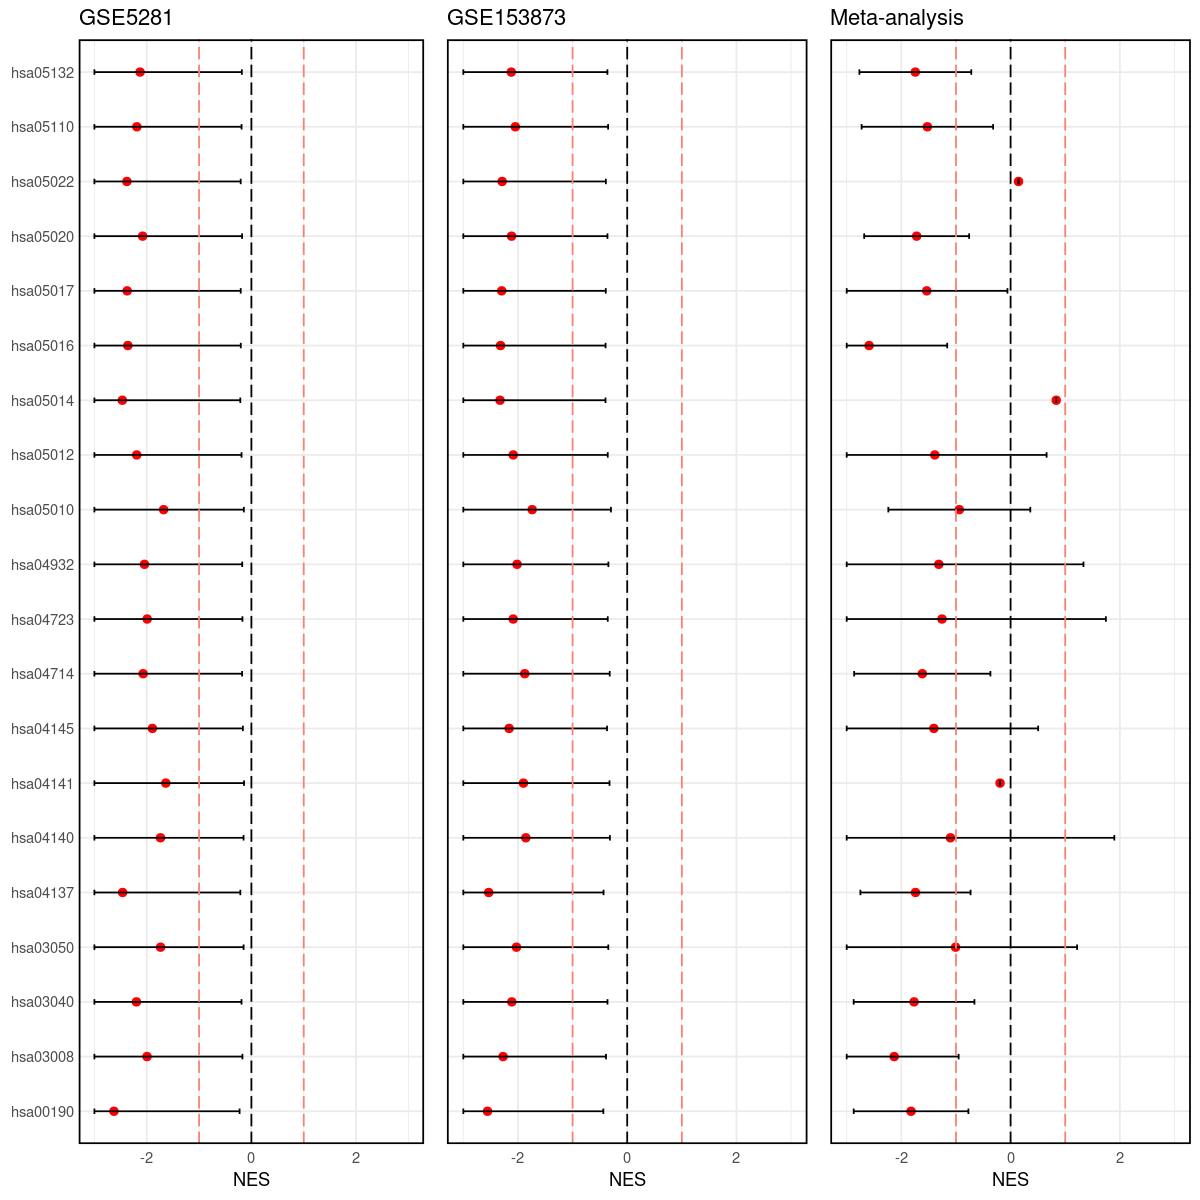

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Combine the three plots and show
plt <- gridExtra::grid.arrange(
    p1 + ggtitle("GSE5281") + 
        scale_y_discrete(labels = pathways) +
        theme(axis.text.y = element_text(hjust = 1)),
    p2 + ggtitle("GSE153873"),
    metaplt + ggtitle("Meta-analysis"),
    ncol = 3,
    widths = c(1.13,1,1)
)
plt

From the above figure, we see that the enrichment scores produced from a meta-analysis using multiple datasets are more significant compared with the ones calculated from a single dataset.


We can plot either a Venn diagram or a Heatmap to show the differences between the pathway analysis results of different datasets. For Venn diagram, we can still utilize the function `plotVenn` which was previously used in [submodule 2](Submodule02-DifferentialAnalysis.ipynb). 

In [19]:
#' @ description This function generates a Venn diagram to visualize the overlap of significant pathways 
#'                 between multiple sets of results.
#'
#' @param aResults A list containing multiple sets of pathway analysis results.
#'                 Each element in the list should be a data frame containing pathway analysis results..
#' @param pThreshold The significance threshold for filtering differentially expressed genes (default: 0.05).
#' @param useFDR A logical value indicating whether to use normal p-value or FDR p-value to filter out the significant pathways
#'
#' @return A Venn diagram displaying the overlap of differentially expressed genes or features among the specified result sets.

plotVenn <- function(aResults, pThreshold = 0.05, useFDR = TRUE) {
    if (length(aResults) < 2) {
        stop("The number of DE results must be at least 2.")
    }

    for (Res in aResults) {
        if (useFDR && !("pFDR" %in% colnames(Res))) {
            stop("The F DR adjusted p-value column is not in the results data frame.")
        } else {
            if (!("p.value" %in% colnames(Res))) {
                stop("The p.value column is not in the results data frame.")
            }
        }

       
    }

    plotDat <- lapply(aResults, function(Res) {
            filtered_df <- filter(data.frame(Res),
                (
                    if (useFDR) {
                        .data$pFDR < pThreshold
                    } else {
                        .data$p.value < pThreshold
                    }
                )
            )
            filtered_df[["ID"]]
    })
    
    if (is.null(names(plotDat))) {
        names(plotDat) <- paste0("Dataset ", seq_along(plotDat))
    }
    pR <- ggvenn::ggvenn(plotDat,
           fill_color = c(
               "#316b9d",
               # "#fce397",
               # "#99cc83",
               "#f77a65",
               "#a6a1d0",
               "#fea9c4",
               "#74e7bc",
               "#febb73",
               "#1db4db",
               "#ffc5a6",
               "#b6c9fa",
               "#ee5437"),
           stroke_size = 0.5,
           set_name_size = 4,
           fill_alpha = 0.75,

    ) 
    
    pR 
}


We can now use visualization methods to compare the difference between pathway analysis results of different datasets and the meta-pathway analysis result. We need to prepare the plot data first, we will include the meta-result in the plot data to create a venn diagram and a heatmap plot.

In [20]:
# Create plot data for the Microarray dataset
GSE5281_result <- plots.enrichment.data[["GSE5281"]]$res
GSE5281_result$p.value <- GSE5281_result$pval
GSE5281_result$ID <- GSE5281_result$pathway

# Create plot data for the RNA-Seq dataset
GSE153873_result <- plots.enrichment.data[["GSE153873"]]$res
GSE153873_result$p.value <- GSE153873_result$pval
GSE153873_result$ID <- GSE153873_result$pathway

# Prepare plot data for the meta result
metaESRes$p.value <- metaESRes$pval
metaESRes$NES <- metaESRes$NES.combined
metaESRes$ID <- metaESRes$pathway
# Add the plot data to a list for the plot functions
PAResults <- list("GSE5281" = GSE5281_result, "GSE153873" = GSE153873_result, "Meta-analysis" = metaESRes)


Now we can create a venn diagram and a heatmap that includes the meta-analysis result using the `plotVenn` function.

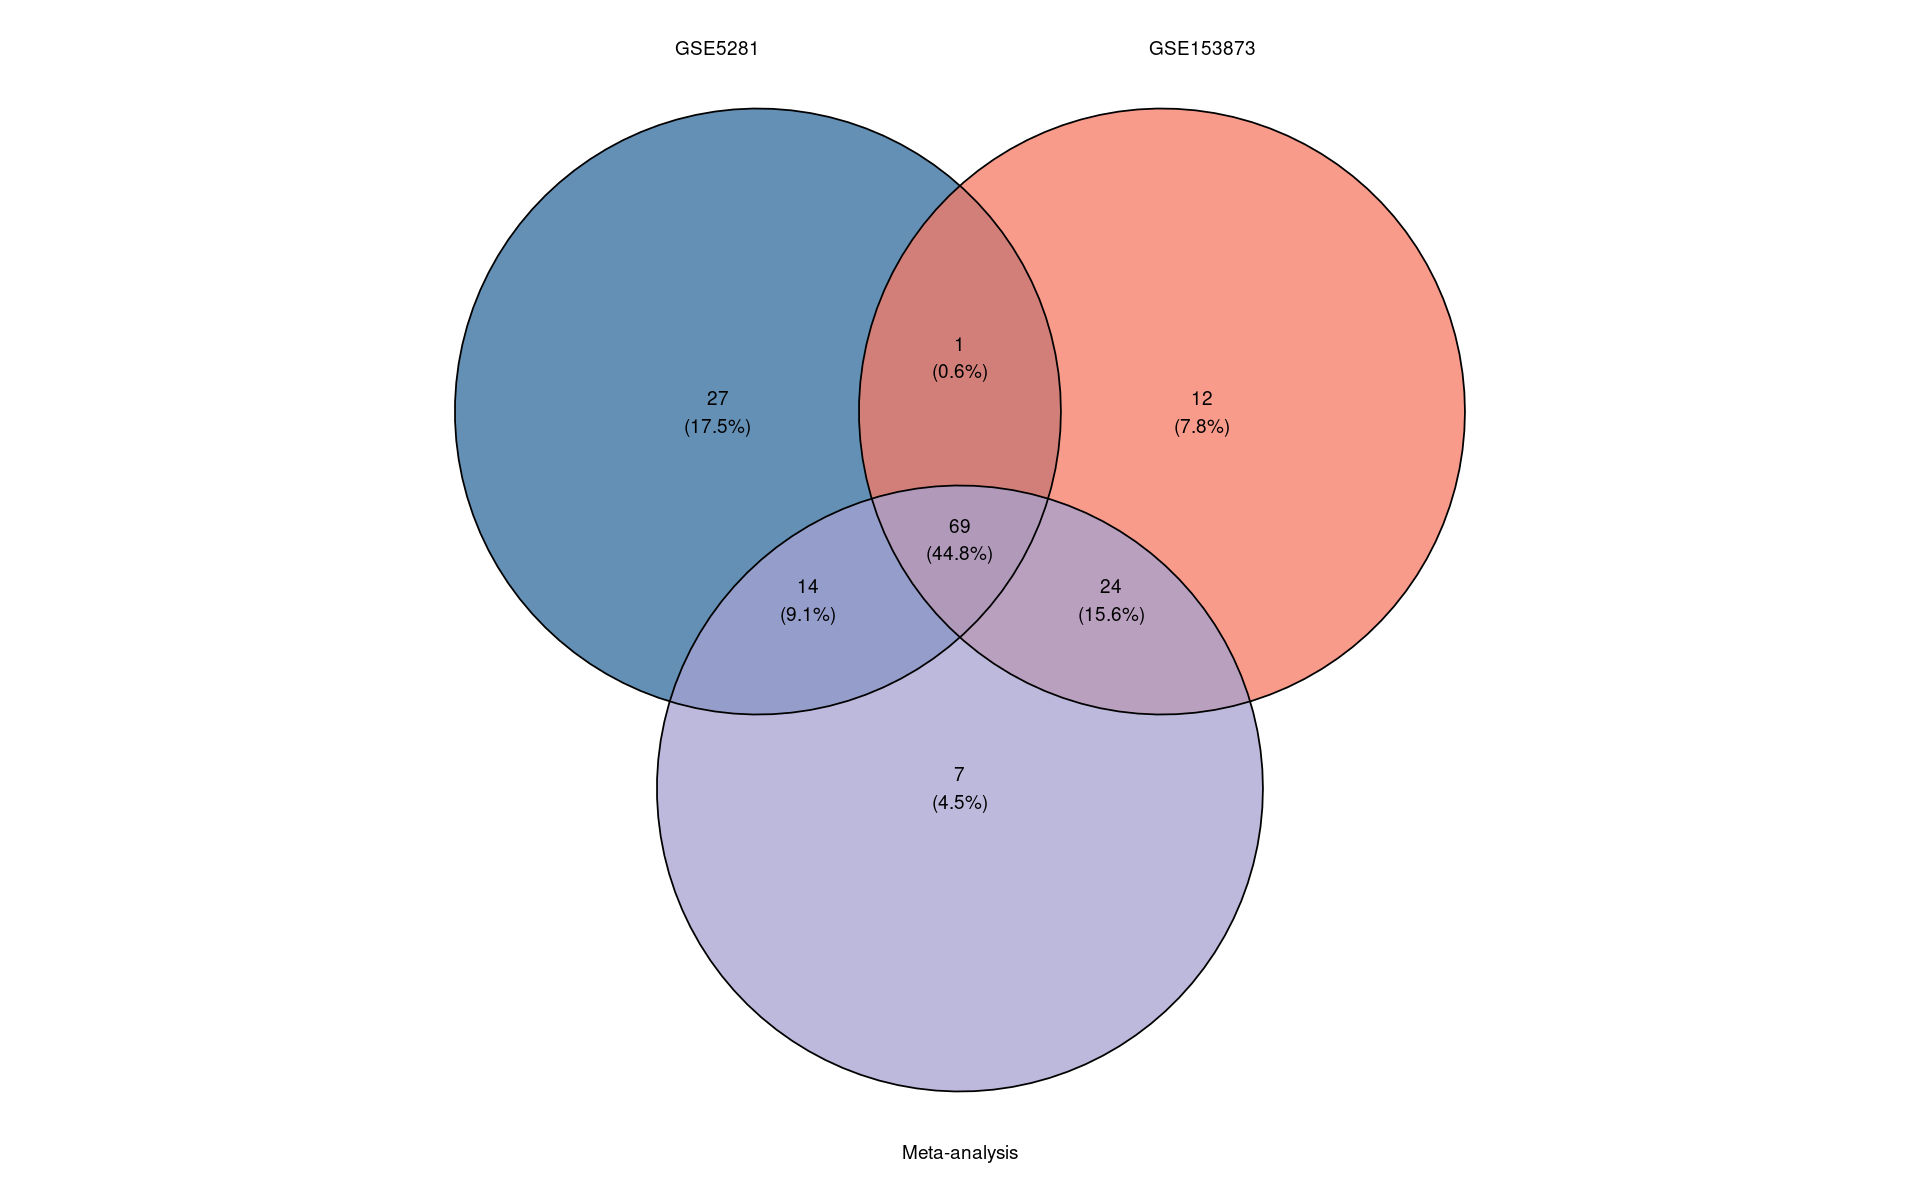

In [21]:
options(repr.plot.width = 16, repr.plot.height = 10)
# Create the Venn pathway for pathway results of different datasets.
plotVenn(PAResults, useFDR = FALSE)

There are 69 common pathways amongs the pathway analysis results of the two datasets and the meta-pathway analysis result.

For heatmap plots of pathway analysis results, we can utilize the function below:

In [22]:
#' @description This function generates a heatmap visualizing pathway analysis results.
#'
#' @param resultsList List of pathway analysis results.
#' @param yAxis Column to be used for the y-axis of the heatmap (default is "ID").
#' @param negLog10pValueLims Limits for the negative logarithm base 10 of p-values (default is c(0, 5)).
#' @param useFDR Logical, whether to use False Discovery Rate (FDR) for p-values (default is TRUE).
#' @param selectedPathways Vector of selected pathway IDs to include in the plot (default is NULL).
#'
#' @return The function returns the heatmap plot.

plotPathwayHeatmap <- function(resultsList, yAxis = "ID", negLog10pValueLims = c(0, 5), useFDR = TRUE, selectedPathways = NULL) {
    # Get the data for the pathway selected, make sure all the order of the results consistent
    if (!is.null(selectedPathways)) {
        resultsList <- lapply(resultsList, function(df) {
            # Filter rows based on selectedPathways
            df <- df[df$ID %in% selectedPathways, ]
            # Get the indices of selectedPathways in the original order
            indices <- match(df$ID, selectedPathways)
            # Reorder the DataFrame based on the indices
            df <- df[order(indices), ]           
            df
        })
    }
    
    studyIDs <- names(resultsList)

    if (any(sapply(studyIDs, is.null))) {
        stop("The names of the input list should be specified.")
    }
    
    checkNS <- lapply(resultsList, function(data) c("NES") %in% colnames(data))
    
    resultsList <- lapply(seq_along(checkNS), function(i) {
      if (!checkNS[[i]]) {
        df <- resultsList[[i]]
        df$NES <- rep(.Machine$double.eps, nrow(df))
        resultsList[[i]] <- df
      } else {
        resultsList[[i]]
      }
    })

    cols_list <- lapply(resultsList, function(data) colnames(data))

    if (!all(sapply(cols_list, function(x) c("ID", "NES", "p.value") %in% x))) {
        stop("All dataframes in the input list must have 'ID', 'NES', and 'p.value' columns.")
    }
                    
    rows_list <- lapply(resultsList, function(data) as.vector(unlist(data$ID)))
    
    if (!all(lengths(rows_list) == length(rows_list[[1]]))) {
        stop("All dataframes in the input list must have the same number of rows.")
    }
    
    initial_names <- sort(as.vector(unlist(resultsList[[1]]$ID)))

    if (!all(sapply(rows_list, function(x) all.equal(sort(x), initial_names)))) {
        stop("All dataframes in the input list must have the same set of pathways.")
    }
    # Prepare the data for plotting
    plotData <- lapply(1:length(resultsList), function(i) {
        data <- resultsList[[i]]
        data <- data[, c("ID", "NES", "p.value")]
        data$dataset <- studyIDs[i]
        data$Direction <- ifelse(data$NES <= 0, "Negative", "Positive")
        data$abs.NES <- abs(as.vector(data$NES))
        as.data.frame(data)
    }) 
    plotData <- do.call(plotData, what = rbind)
    
    plotData$Direction <- factor(plotData$Direction, levels = c("Positive", "Negative"))

    
    plotData$logP <- if (useFDR) -log10(plotData$pFDR) else -log10(plotData$p.value)

    grouped_data <- arrange(
        dplyr::summarize(
            group_by(plotData, ID),
            avgLogP = mean(logP, na.rm = TRUE)
        ),
        avgLogP
    )
    
    pathwayOrder <- pull(grouped_data, ID)

    plotData$dataset <- factor(plotData$dataset, levels = studyIDs)
    plotData$ID <- factor(plotData$ID, levels = pathwayOrder)
    yLabels <- pull(arrange(unique(select(plotData, "ID", sym(yAxis))), as.numeric(ID)), sym(yAxis))

    scaleMinMax <- function(x, minx, maxx) {
        x[x < minx] <- minx
        x[x > maxx] <- maxx
        x
    }

    if (yAxis == "ID") {
        plotData$yLabel <- plotData$ID
    }else {
        plotData$yLabel <- plotData$name
    }

    plotData$p.value.scaled <- scaleMinMax(abs(log10(
        if (useFDR) plotData$pFDR else plotData$p.value)), 
            negLog10pValueLims[1], negLog10pValueLims[2])

    # Create the plot
    ggplot(plotData, aes(y = .data$ID, x = factor(.data$dataset))) +
        geom_tile(
            aes(fill = .data$p.value.scaled)
        ) +
        scale_fill_continuous(
            low = "white",
            high = "#CD5C5C",
            limits = c(negLog10pValueLims[1], negLog10pValueLims[2]),
            breaks = c(negLog10pValueLims[1], (negLog10pValueLims[1] + negLog10pValueLims[2]) / 2, negLog10pValueLims[2]),
        ) +
        labs(fill = paste0("-log10", ifelse(useFDR, " pFDR", " p-value"))) +

        new_scale_fill() +
        geom_point(
            aes(
                fill = .data$Direction,
                size = .data$abs.NES
            ),
            shape = 21,
            color = "white",
            stroke = 0.5
        ) +
        scale_y_discrete(
            labels = yLabels
        ) +
        scale_size_continuous(
            guide = guide_legend(override.aes = list(shape = 21, fill = "gray50"))
        ) +
        scale_fill_manual(
            values = c("Positive" = "#FFAA1D", "Negative" = "#72A0C1"),
            guide = guide_legend(override.aes = list(shape = 21, size = 8), title = element_text("Sign"))
        ) +
        labs(
            size = "Normalized score",
            x = "",
            y = "") +

        theme_bw() + 
        
      
      ggplot2::theme(plot.title = element_text(hjust = 0.5))
}

In [23]:
# Create a pathway list to plot, here we will use common pathways of three Alzheimer's datasets that have NES > 0.5 and p-value < 0.05

plotDat <- lapply(PAResults, function(Res) {
    filtered_df <- filter(data.frame(Res),
        abs(.data[["NES"]]) > 0.5 & (.data$p.value < 0.05)
    )
    filtered_df[["ID"]]
})
# Select the common pathways between analyses result for plotting
selectedPathways <- Reduce(intersect, plotDat)
# The resulting pathways will be the same as common pathways in the venn diagram
length(selectedPathways)

[1] 69

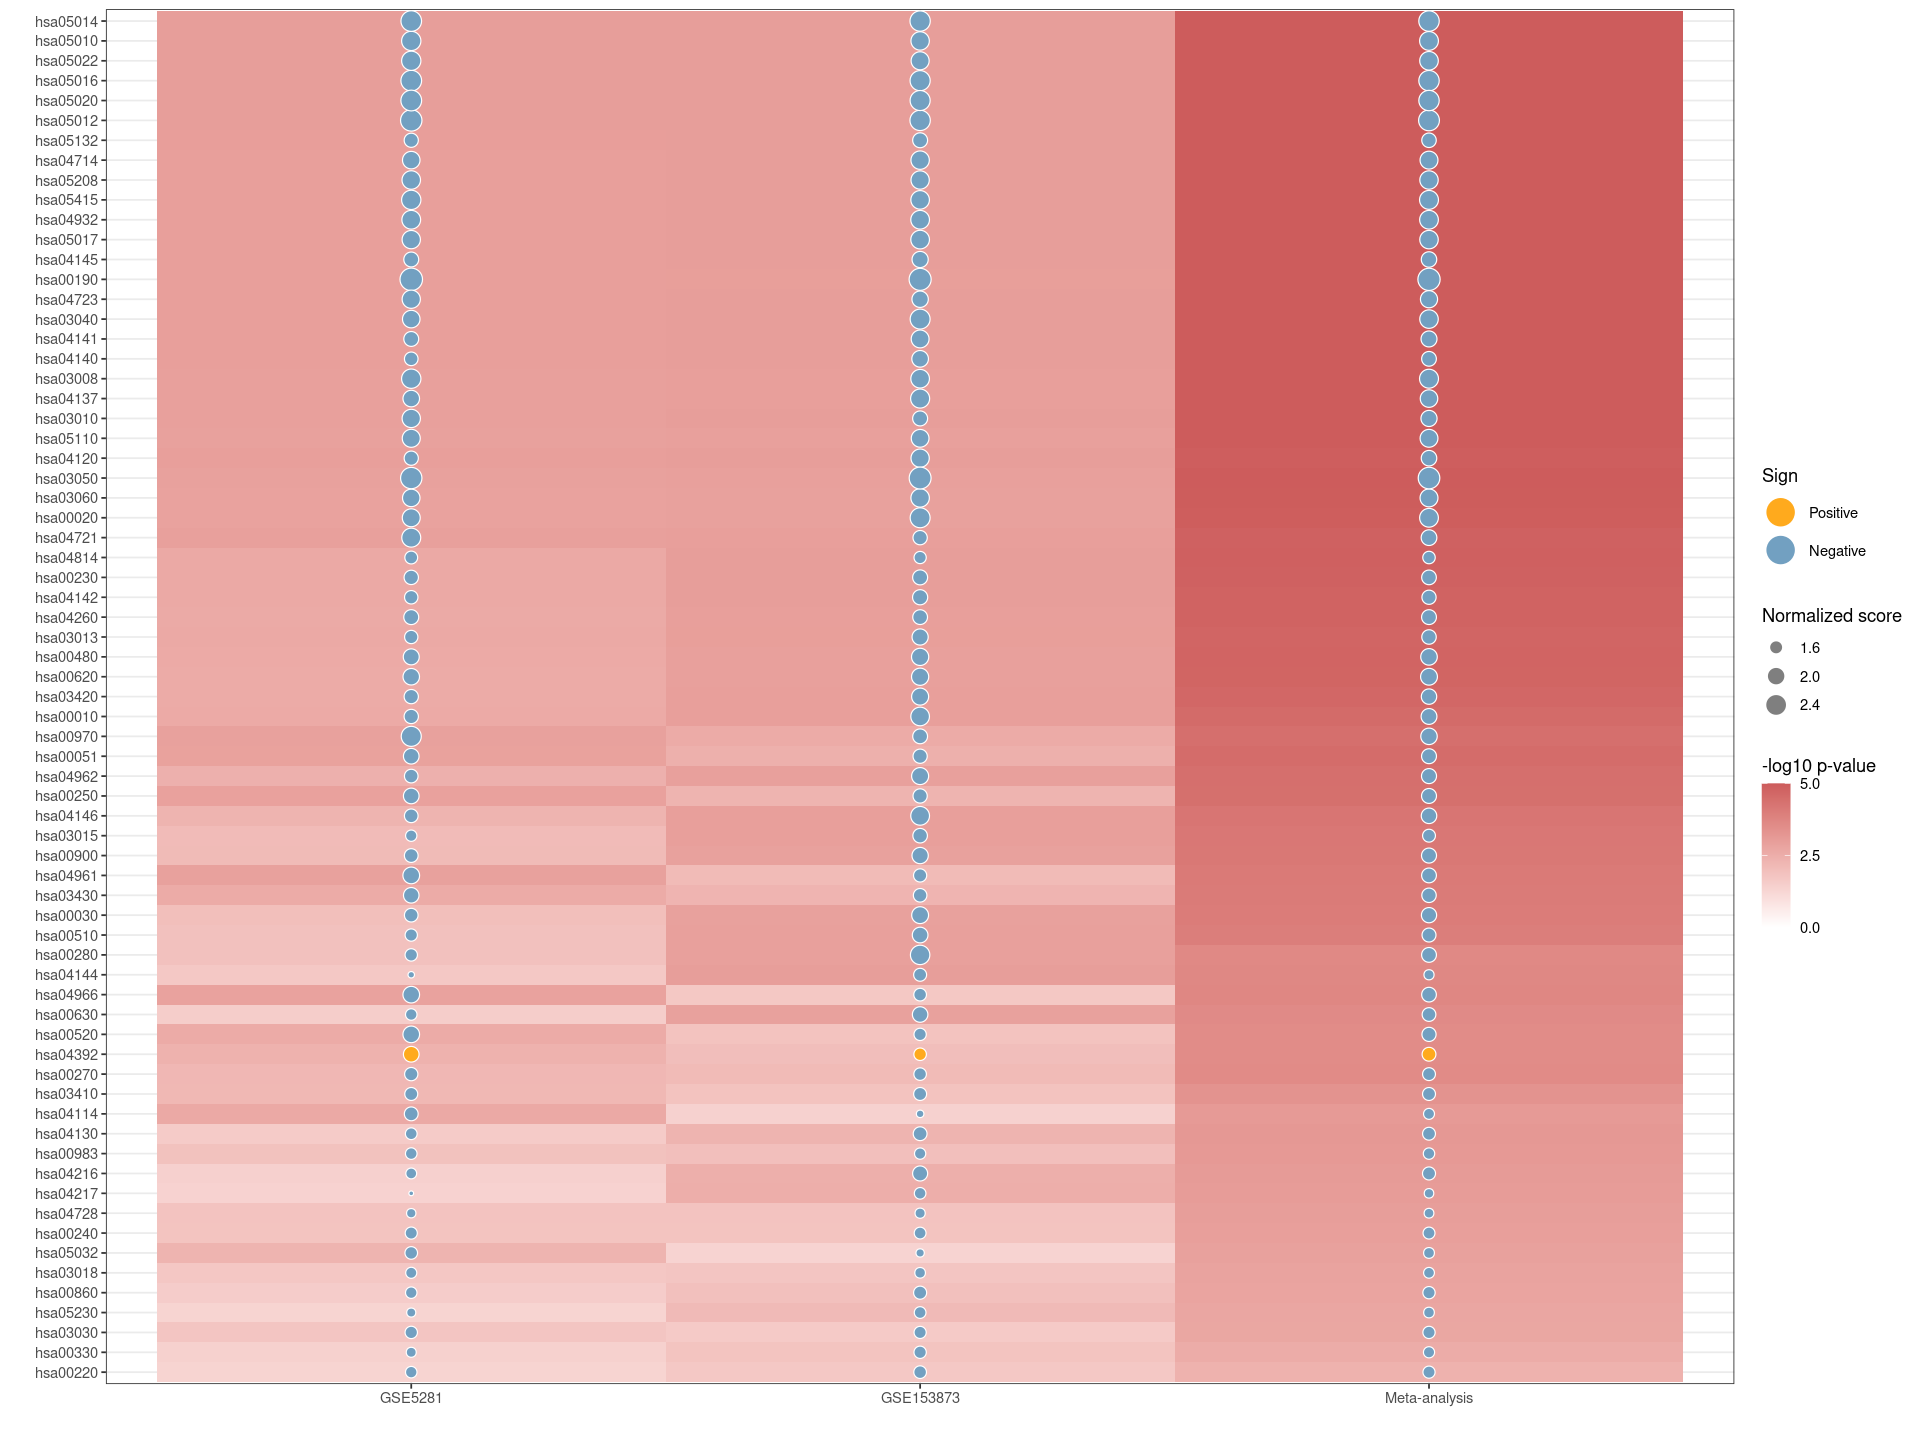

In [24]:
# Create the heatmap plot
options(repr.plot.width = 16, repr.plot.height = 12)
# Plot heatmap for common pathways
plotPathwayHeatmap(PAResults, yAxis = "ID", useFDR = FALSE, selectedPathways = selectedPathways)

# Conclusion

 In this course, we have successfully completed pathway analysis using omics data in five submodules that cover different aspects of bioinformatics analysis. The first submodule, Data Processing, introduces the fundamental concepts of preprocessing and quality control of microarray data obtained from Gene Expression Omnibus. The second submodule, Differential Expression Analysis, focuses on how to analyze gene expression data to identify genes that are differentially expressed between two or more conditions. The third submodule, Gene Set and Pathway shows us how to use different R libraries to obtain pathways and GO terms with associated gene lists. The fourth submodule, Enrichment Analysis, focuses on the identification of enriched biological pathways or functional categories within a set of genes of interest. Finally, the fifth submodule, Meta Analysis, covers the techniques of meta-analysis which is a statistical approach to combine the results of multiple independent studies. Overall, the cloud learning module provides a comprehensive and practical guide for researchers to analyze and interpret their genomic data using various bioinformatics tools and techniques.

In [25]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.13.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0        meta_7.0-0          metadat_1.2-0      
 [4] fgsea_1.28.0        ggnewscale_0.4.10   ggvenn_0.1.10      
 [7] ggplot2_3.5.0       tidyr_1.3.1         dplyr_1.1.4        
[10] cow